# UCI Heart Data Model

Creating various machine learning models for UCI Heart Data and comparing the accuracy of different classifiers.

Written by Prateek Dullur, Shanti Polara, David Casente, Aiden Gindin, and Paige Biggs

## Set up libraries and import data

In [ ]:
!pip install shap flask-ngrok optuna

In [2]:
import shap
import xgboost
import lightgbm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc,recall_score,precision_score
from flask import Flask, render_template, request, redirect, url_for, Response
from flask_ngrok import run_with_ngrok
from datetime import datetime
from io import StringIO
from werkzeug.wrappers import Response
import matplotlib.pylab as pl
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [21]:
# read in data file
heart_data = pd.read_csv("/content/drive/My Drive/AI In Healthcare/Project 2/heart_data_resampled.csv")

# turn data into data frame
heart_data_db = pd.DataFrame(heart_data)

##Exploratory Analysis

Find size and dimensions of the data set

In [ ]:
heart_data_db.shape

(10302, 14)

Number of predictors in the data set

In [ ]:
# Number of predictors in data set (not counting target column or numbering column)
print(len(heart_data_db.columns) - 2)

13


Take a look at the values in the data set

In [ ]:
heart_data_db

,Unnamed: 0,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,0,63.000000,1.000000,3.000000,145.000000,233.000000,1.000000,0.000000,150.000000,0.000000,2.300000,0.000000,0.0,1.000000,1.0
1,1,37.000000,1.000000,2.000000,130.000000,250.000000,0.000000,1.000000,187.000000,0.000000,3.500000,0.000000,0.0,2.000000,1.0
2,2,41.000000,0.000000,1.000000,130.000000,204.000000,0.000000,0.000000,172.000000,0.000000,1.400000,2.000000,0.0,2.000000,1.0
3,3,56.000000,1.000000,1.000000,120.000000,236.000000,0.000000,1.000000,178.000000,0.000000,0.800000,2.000000,0.0,2.000000,1.0
4,4,57.000000,0.000000,0.000000,120.000000,354.000000,0.000000,1.000000,163.000000,1.000000,0.600000,2.000000,0.0,2.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,10297,56.494504,0.498901,1.002198,122.967023,268.995603,0.000000,0.000000,174.483511,0.000000,0.000000,2.000000,0.0,2.000000,1.0
10298,10298,54.192905,1.000000,1.403547,132.982264,195.508868,0.701774,0.298226,150.807095,0.000000,0.961419,0.298226,0.0,1.701774,1.0
10299,10299,55.058003,1.000000,2.000000,124.534298,255.732851,0.151143,0.151143,145.488567,0.151143,0.490686,1.000000,0.0,2.848857,1.0
10300,10300,51.485479,0.757261,2.000000,106.796700,220.543564,0.000000,0.757261,136.203300,0.757261,0.908713,1.242739,0.0,1.514521,1.0


Let's rename some of the variables to make them more readable and also get rid of the first column 

In [22]:
heart_data_db = heart_data_db.rename(columns={"age": "Age", "sex": "Sex", "cp": "Chest Pain", "trestbps": "Resting BP", "restecg": "Resting ECG", "chol": "Serum Cholesterol", "fbs": "Fasting Blood Sugar > 120 mg/dl", "thalach": "Thalach", "thal": "Thal", "ca": "Number of major Blood Vessels", "exang": "Exercise Induced Angina", "oldpeak": "Exercise-induced ST depression", "slope": "Slope", "target": "Target" })
heart_data_db.drop(heart_data_db.columns[0], axis=1, inplace=True)
heart_data_db.rename(columns = lambda x: x.replace(' ', '_'), inplace=True)
heart_data_db

,Age,Sex,Chest_Pain,Resting_BP,Serum_Cholesterol,Fasting_Blood_Sugar_>_120_mg/dl,Resting_ECG,Thalach,Exercise_Induced_Angina,Exercise-induced_ST_depression,Slope,Number_of_major_Blood_Vessels,Thal,Target
0,63.000000,1.000000,3.000000,145.000000,233.000000,1.000000,0.000000,150.000000,0.000000,2.300000,0.000000,0.0,1.000000,1.0
1,37.000000,1.000000,2.000000,130.000000,250.000000,0.000000,1.000000,187.000000,0.000000,3.500000,0.000000,0.0,2.000000,1.0
2,41.000000,0.000000,1.000000,130.000000,204.000000,0.000000,0.000000,172.000000,0.000000,1.400000,2.000000,0.0,2.000000,1.0
3,56.000000,1.000000,1.000000,120.000000,236.000000,0.000000,1.000000,178.000000,0.000000,0.800000,2.000000,0.0,2.000000,1.0
4,57.000000,0.000000,0.000000,120.000000,354.000000,0.000000,1.000000,163.000000,1.000000,0.600000,2.000000,0.0,2.000000,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10297,56.494504,0.498901,1.002198,122.967023,268.995603,0.000000,0.000000,174.483511,0.000000,0.000000,2.000000,0.0,2.000000,1.0
10298,54.192905,1.000000,1.403547,132.982264,195.508868,0.701774,0.298226,150.807095,0.000000,0.961419,0.298226,0.0,1.701774,1.0
10299,55.058003,1.000000,2.000000,124.534298,255.732851,0.151143,0.151143,145.488567,0.151143,0.490686,1.000000,0.0,2.848857,1.0
10300,51.485479,0.757261,2.000000,106.796700,220.543564,0.000000,0.757261,136.203300,0.757261,0.908713,1.242739,0.0,1.514521,1.0


Let's start by getting an idea of the distributions of our predictor and response variables. First we can see that our response variable, target, is binary meaning our model goal is to predict whether heart disease is present or not. We can see that most predictor variables are continuous and a few are binary as well. In some of the variables we can see clear bimodal distributions, which could help with distinguishing between our two outcomes.

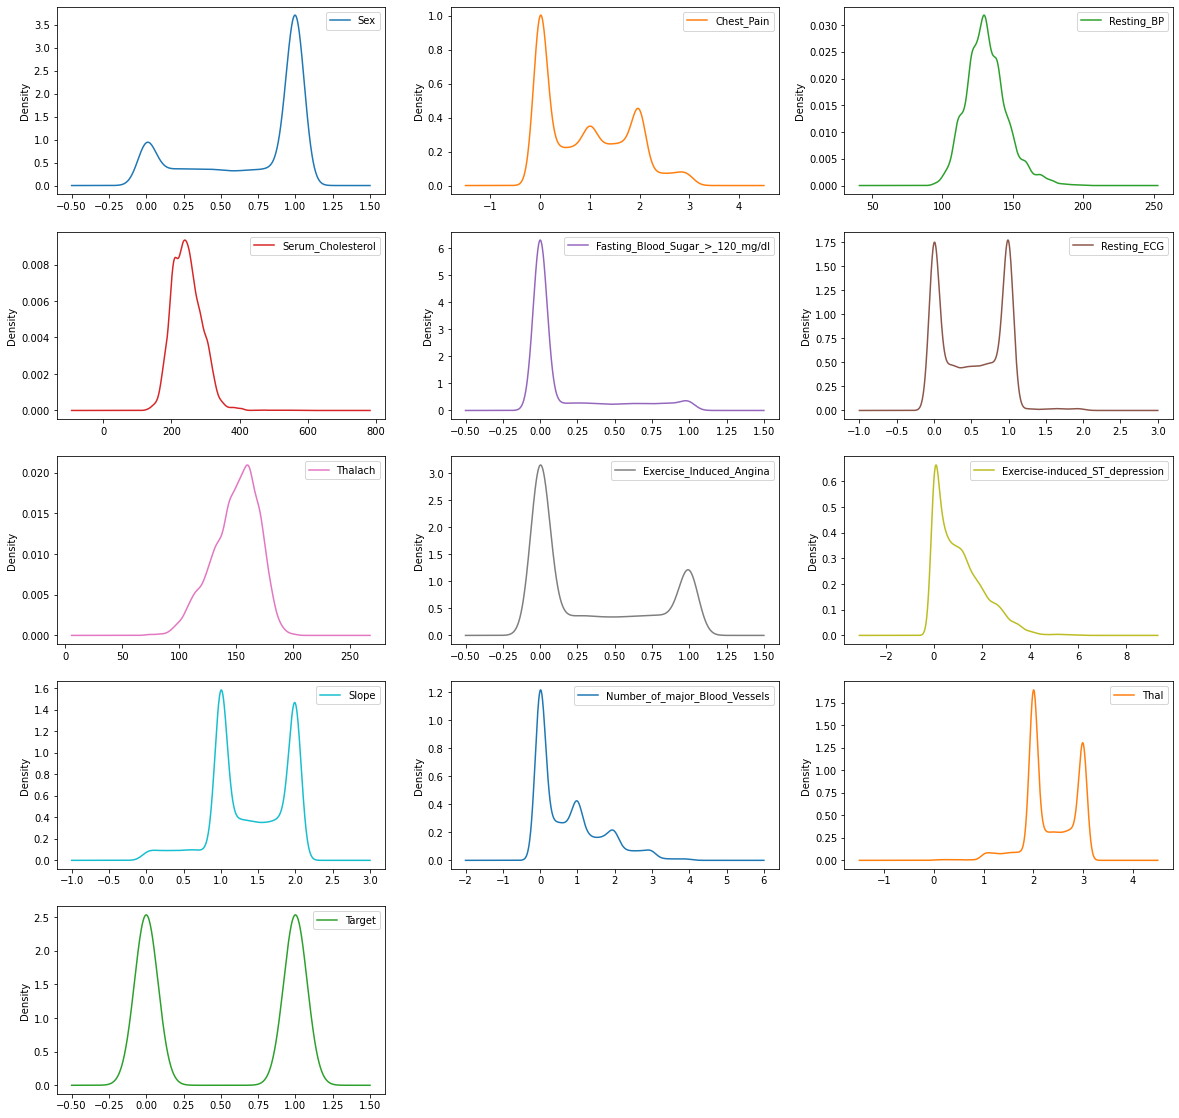

In [8]:
heart_data_db.plot(kind='density', subplots=True, layout=(5,3), figsize=(20,20), sharex=False)
pl.show()

Now let's take a look at the correlation between our variables and see if there are any distinct relationships that can help us determine what model we should use. There is a particularly close relationship between the Exercise Induced Angina and Exercise-induced ST depression variables which we can look into. In terms of predictor relationships with the response variable, Exercise Induced Angina, Exercise-induced ST depression, Number of major Blood Vessels > 120 mg/dl, and Thal have the strongest negative correlation, while Chest Pain, thalach and slope have the strongest positive correlation. 

Correlation Matrix
- Finds correlations between variables to find most impactful set of values

,Sex,Chest_Pain,Resting_BP,Serum_Cholesterol,Fasting_Blood_Sugar_>_120_mg/dl,Resting_ECG,Thalach,Exercise_Induced_Angina,Exercise-induced_ST_depression,Slope,Number_of_major_Blood_Vessels,Thal,Target
Sex,1.000000,-0.117550,-0.082024,-0.185393,0.026311,-0.057023,-0.099737,0.185493,0.156386,-0.074315,0.161209,0.253203,-0.339179
Chest_Pain,-0.117550,1.000000,0.027100,-0.096639,0.072023,0.069917,0.339703,-0.452838,-0.225150,0.177317,-0.242189,-0.237984,0.499288
Resting_BP,-0.082024,0.027100,1.000000,0.153625,0.163300,-0.132670,-0.076562,0.069479,0.184550,-0.130646,0.113428,0.056646,-0.154071
Serum_Cholesterol,-0.185393,-0.096639,0.153625,1.000000,0.027524,-0.164466,-0.060388,0.092907,0.040321,0.003166,0.109870,0.096217,-0.114896
Fasting_Blood_Sugar_>_120_mg/dl,0.026311,0.072023,0.163300,0.027524,1.000000,-0.104057,-0.008334,0.047955,-0.002585,-0.057326,0.156447,-0.067737,-0.036593
Resting_ECG,-0.057023,0.069917,-0.132670,-0.164466,-0.104057,1.000000,0.067369,-0.093207,-0.075477,0.112011,-0.107193,-0.049292,0.168959
Thalach,-0.099737,0.339703,-0.076562,-0.060388,-0.008334,0.067369,1.000000,-0.442292,-0.415557,0.454558,-0.272008,-0.159472,0.482556
Exercise_Induced_Angina,0.185493,-0.452838,0.069479,0.092907,0.047955,-0.093207,-0.442292,1.000000,0.353107,-0.320355,0.190510,0.254091,-0.494982
Exercise-induced_ST_depression,0.156386,-0.225150,0.184550,0.040321,-0.002585,-0.075477,-0.415557,0.353107,1.000000,-0.603682,0.291642,0.257910,-0.508860
Slope,-0.074315,0.177317,-0.130646,0.003166,-0.057326,0.112011,0.454558,-0.320355,-0.603682,1.000000,-0.158985,-0.137340,0.418801


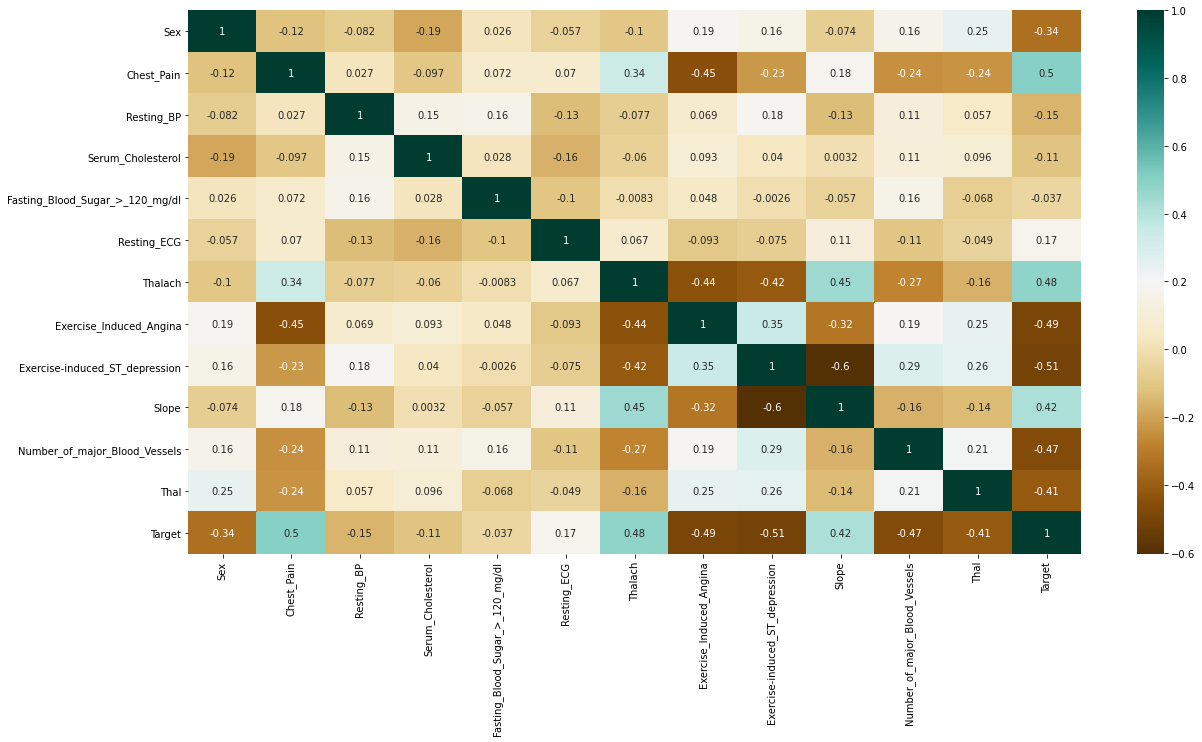

In [9]:
pl.figure(figsize=(20,10));
c= heart_data_db.corr();
sns.heatmap(c,cmap="BrBG",annot=True)
c

Let's take a look at the most correlated variables, slope and Exercise-induced_ST_depression. If we take a look at the description of each variable, it makes sense that they are correlated because they both are measurements from an exercise test, one measuring the peak of a depression and the other measuring the slope. Observations with a high peak are likely to have a steep slope. In the graph we can see a pretty strong negative relationship between the variables, but it is quite noisy.

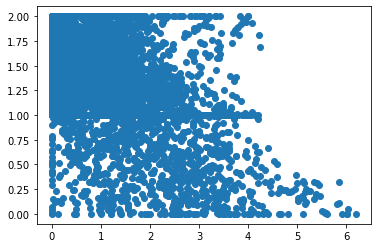

In [10]:
oldpeak  = heart_data_db["Exercise-induced_ST_depression"]
slope = heart_data_db["Slope"]


pl.scatter( oldpeak, slope,label = "Exercise Induced Angina")

Now lets take a look at the positively correlated variables and how well it maps to the binary outcome variable. Looking at the boxplots of each variable seperated based on the outcome, we can see that each subset is pretty distinguishable from the other within the interquartile range, but there is definite overlap with outliers and tails. This indicates that there is a relationship, but a simple logistic regression model would struggle to seperate the observations into the correct response and would be a poor model choice. So we would need a more complicated model, such as XGBoost to capture the relationships.  

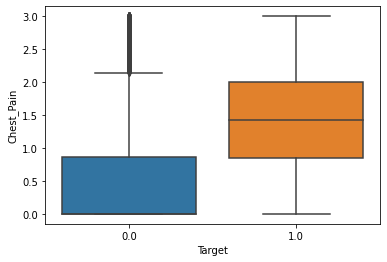

In [11]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Chest_Pain')

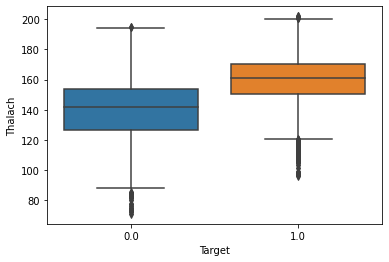

In [12]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Thalach')

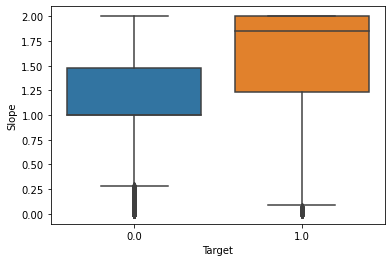

In [13]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Slope')

Now looking at the negatively correlated variables we see something similar. Again the interquartile range of the subsets is pretty dicernable, but there are a lot of outliers outside of that which overlap with each other, especially for the target= 1 subset. This noisy relationship again indicates the need for a more complicated model to properly capture it rather than a simple logistic regression model.

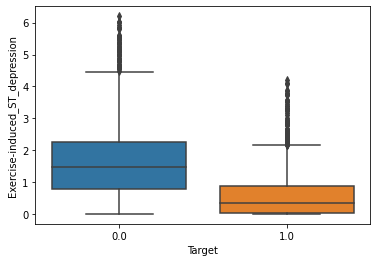

In [14]:
sns.boxplot(data = heart_data_db, x = 'Target', y = "Exercise-induced_ST_depression")


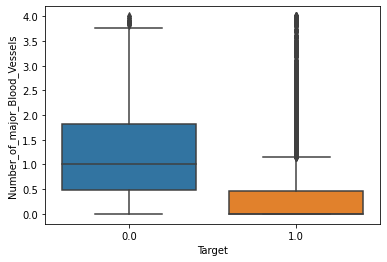

In [15]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Number_of_major_Blood_Vessels')

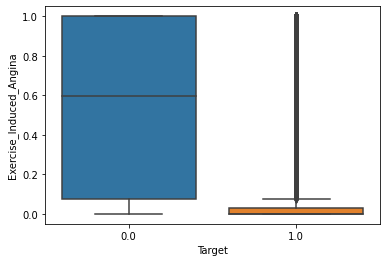

In [16]:
sns.boxplot(data = heart_data_db, x = 'Target', y = 'Exercise_Induced_Angina')

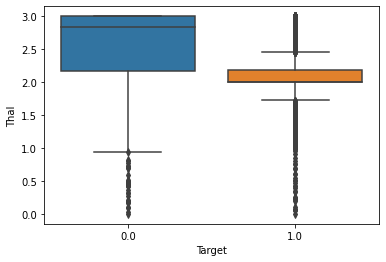

In [17]:
sns.boxplot(data = heart_data_db, x = 'Target', y = "Thal")

## Create XGBoost data objects

This uses a pre-processed subset of Heart Disease data available from UCI. We split the dataframe into the predictors and the labels, and then create an 80/20 train/test split.


In [23]:
# Load the dataframe into subsets for data and labels
X = heart_data_db.loc[:,'Age':'Thal']
y = heart_data_db.loc[:,'Target'].to_numpy();

In [24]:
# create a train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
xgb_train = xgboost.DMatrix(X_train, label=y_train)
xgb_test = xgboost.DMatrix(X_test, label=y_test)

## Train XGBoost model

Here, we are using a custom function that fits the XGB Classifier to our model and also cross validates it each boosting round (using 5-fold CV). The function was adapted from Aarshay Jain's blog post: https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [25]:
def modelfit(alg, dtrain, labels, test, testlabels, useTrainCV=True, cv_folds=5, early_stopping_rounds=10):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgboost.DMatrix(X_train, y_train)
        cvresult = xgboost.cv(xgb_param, xgtrain, verbose_eval=1000, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        print(cvresult)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain, labels,eval_metric='logloss')
        
    #Predict training set:
    preds = alg.predict(test)
    test_pred = []
    for val in preds:
      if val >= 0.5:
          test_pred.append(1)
      else :
          test_pred.append(0)

    #Print model report:
    print("\nModel Report")
    cf_matrix = confusion_matrix(testlabels, test_pred)
    report = classification_report(testlabels, test_pred)
    print ("Confusion Matrix")
    print(cf_matrix)
    print(report)
    return alg

In [26]:
from xgboost import plot_tree
from xgboost import XGBClassifier
from xgboost import cv

xgb2 = XGBClassifier(
 learning_rate =0.002,
 n_estimators=20000,
 max_depth=3,
 verbose_eval=1000,
 eval_metric='logloss',
 min_child_weight=6,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 early_stopping_rounds=10,
 seed=7);
#xgb2.fit(X_train, y_train)
modelfit(xgb2, X_train, y_train, X_test, y_test)

[0]	train-logloss:0.691941+1.04307e-05	test-logloss:0.691966+1.29151e-05
[1000]	train-logloss:0.260466+0.00168727	test-logloss:0.267878+0.00462552
[2000]	train-logloss:0.174351+0.00192732	test-logloss:0.18574+0.00597319
[3000]	train-logloss:0.139948+0.0018343	test-logloss:0.154551+0.0066359
[4000]	train-logloss:0.120425+0.00173273	test-logloss:0.137653+0.00676939
[5000]	train-logloss:0.106459+0.00151252	test-logloss:0.125858+0.00665833
[6000]	train-logloss:0.095496+0.00134018	test-logloss:0.116618+0.00652291
[7000]	train-logloss:0.0864066+0.00123998	test-logloss:0.109094+0.00629143
[8000]	train-logloss:0.0787594+0.0011149	test-logloss:0.10278+0.00628411
[9000]	train-logloss:0.0721984+0.00106168	test-logloss:0.0974362+0.00618622
[10000]	train-logloss:0.0663872+0.00100404	test-logloss:0.0926834+0.00615639
[11000]	train-logloss:0.061234+0.000935019	test-logloss:0.0884736+0.00609945
[12000]	train-logloss:0.0566918+0.000946291	test-logloss:0.0848132+0.00589941
[13000]	train-logloss:0.052665

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, eval_metric='logloss', gamma=0,
              learning_rate=0.002, max_delta_step=0, max_depth=3,
              min_child_weight=6, missing=None, n_estimators=20000, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=7,
              silent=None, subsample=0.5, verbose_eval=1000, verbosity=1)

Here is an example of one of the trees generated in the XGBoost ensemble

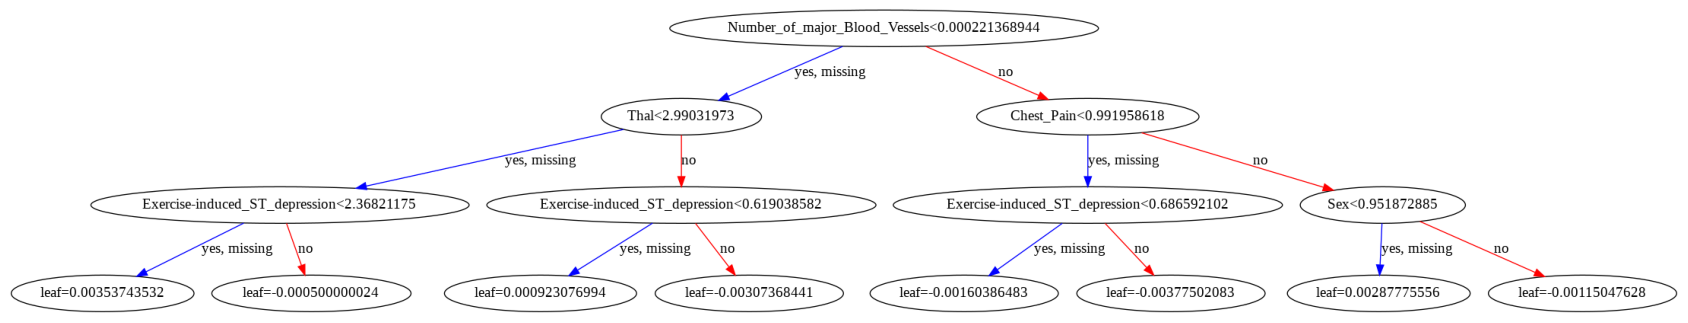

In [27]:
fig, ax = pl.subplots(figsize=(30, 30))
plot_tree(xgb2,num_trees=0, ax=ax)
pl.show()

## Explain the model's predictions by using SHAP

---



In [ ]:
# compute SHAP values 
shap_values = shap.TreeExplainer(xgb2).shap_values(X) 
explainer = shap.Explainer(xgb2, X)
shap_values_bar = explainer(X)

100%|===================| 10299/10302 [62:19<00:01]       

### SHAP Summary Plot

The summary plot and bar plots evaluate the effects of individual features (or predictors) on the models outcome, and it ranks which features matter the most for determining heart disease.

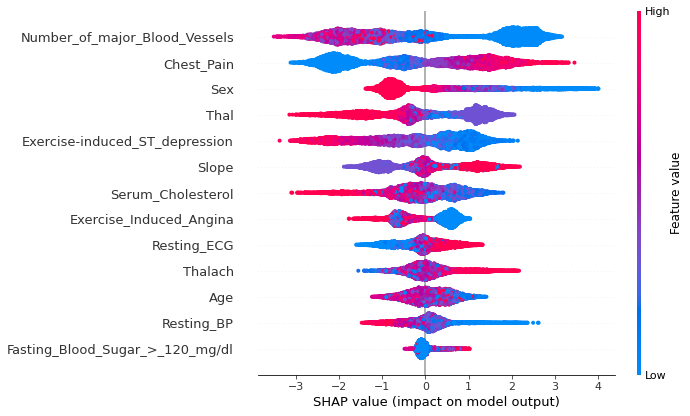

In [ ]:
shap.summary_plot(shap_values, X)

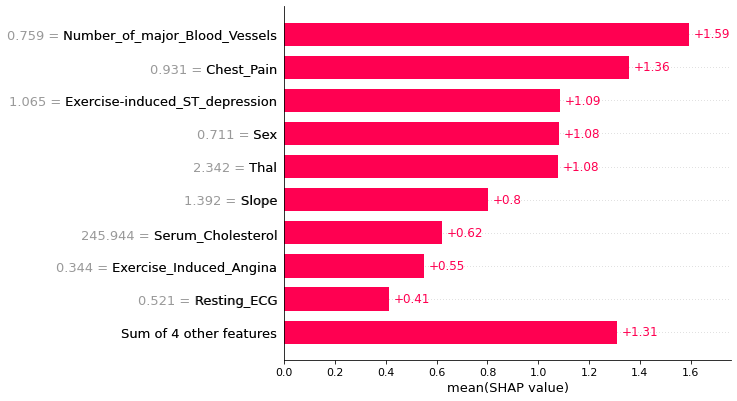

In [ ]:
shap.plots.bar(shap_values_bar)

## Compute SHAP Interaction Values

The interaction summary plot identifies the relations between variables, similar to the correlation plot from earlier, but with the model used as a baseline.

In [ ]:
# takes a couple minutes since SHAP interaction values take a factor of 2 * # features
# more time than SHAP values to compute, since this is just an example we only explain
# the first 2,000 people in order to run quicker
shap_interaction_values = shap.TreeExplainer(xgb2).shap_interaction_values(X.iloc[:,:])

### SHAP Interaction Value Summary Plot

A summary plot of a SHAP interaction value matrix plots a matrix of summary plots with the main effects on the diagonal and the interaction effects off the diagonal.

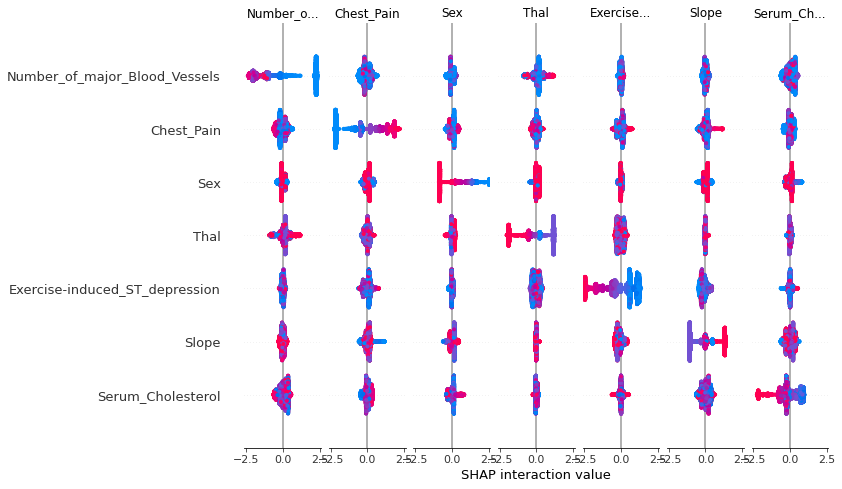

In [ ]:
shap.summary_plot(shap_interaction_values, X.iloc[:,:])

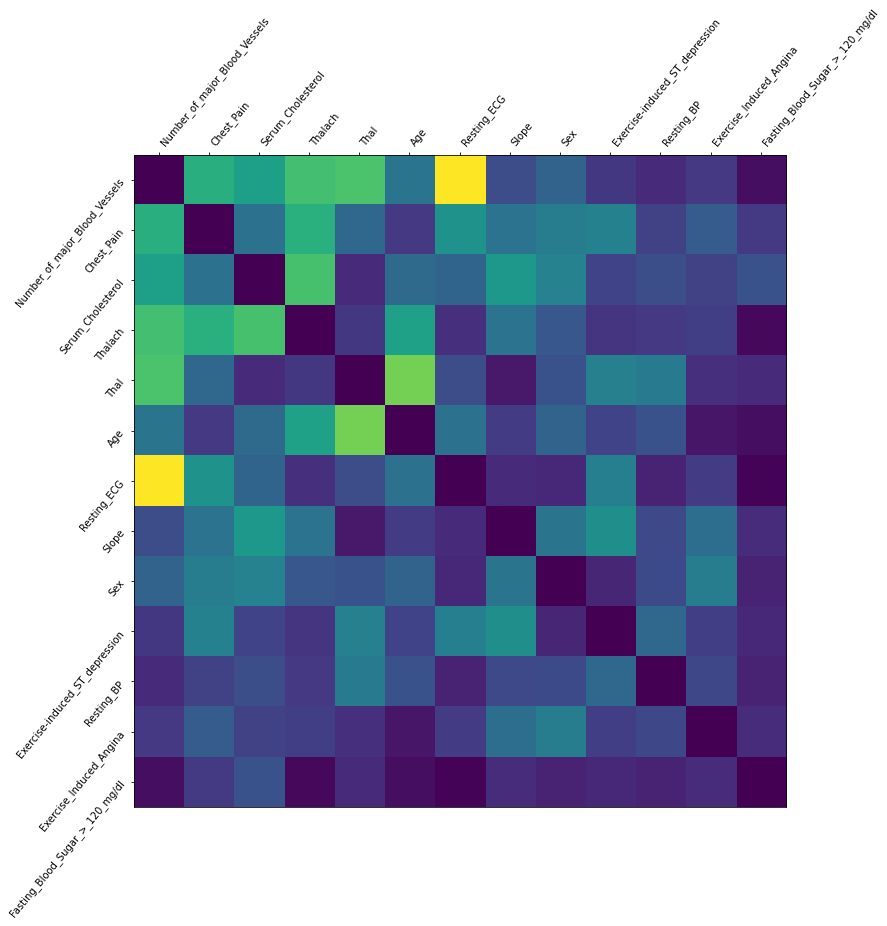

In [ ]:
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

## Using XGBoost Model to Predict Test Values

Run on test set to evaluate model performance. We call the predict_proba function to generate an array of probablities for heart disease for each datapoint in the testing set.

In [28]:
preds = xgb2.predict_proba(X_test)
preds = np.delete(preds, 0, 1)

Convert Percentages into bianary classification

In [45]:
test_pred = []
for val in preds[:,]:
  if val >= 0.5:
      test_pred.append(1)
  else :
      test_pred.append(0)

Create Confusion Matrix and display (again). Here is a graphic describing the confusion matrix and the relevant metrics. We will use those metrics to evaluate our model. Image taken from: https://manisha-sirsat.blogspot.com/2019/04/confusion-matrix.html

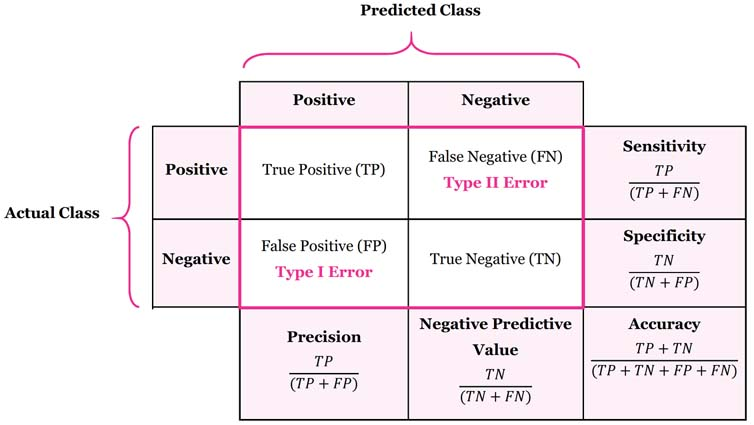

**Performance Metrics**

Accuracy
- percentage of values predicted correctly

Recall/Sensitivity
- percentage of positive values predicted correctly

Specificity
- percentage of negative values that were predicted correctly

Precision
- percentage of values that were predicted as positive that were actually postive

Specificity
- percentage of negative values that were predicted correctly

Negative Predictive Value
- of the values that were predicted as negative, what percentage were actually negative


Area Under the Receiver Operating Characteristics curve (AU-ROC)


*  Measures how good the model is at distinguishing between classes 


Create functions for algorithm analysis

In [30]:
# create confusion matrix. This is the same as the one printed by the modelfit function

def cf_matrix(y_test_data, y_test_predicted):
  matrix = confusion_matrix(y_test_data, y_test_predicted)
  report = classification_report(y_test_data, y_test_predicted)
  print ("Confusion Matrix")
  print(matrix)
  print(report)
  group_names = ["True Neg","False Pos","False Neg","True Pos"]
  group_labels = ["{}\n".format(value) for value in group_names]
  group_counts = ["{0:0.0f}\n".format(value) for value in matrix.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in matrix.flatten()/np.sum(matrix)]
  box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
  labels = np.asarray(box_labels).reshape(matrix.shape[0],matrix.shape[1])
  sns.heatmap(matrix, annot=labels, fmt="", cmap='Blues')
  return matrix

def accuracy(tp, tn, fp, fn):
  print("Accuracy:")
  print("%.2f" %  ((tp + tn) / (tp + fp + fn + tn)))
  print("\n")

def recall(tp, fn):
  print("Recall: ")
  print("%.2f" %  (tp / (tp + fn)))
  print("\n")

def precision(tp, fp):
  print("Precision: ")
  print("%.2f" %  (tp / (tp + fp)))
  print("\n")

def specificity(tn, fp):
  print("Specificity: ")
  print("%.2f" %  (tn / (tn + fp)))
  print("\n")

def neg_pred_value(tn, fn):
  print("Negative Predictive Value:")
  print("%.2f" %  (tn / (tn + fn)))
  print("\n")

def area_under_ROC(y_test_actual_values, y_test_predicted_values):
  fpr, tpr, _ = roc_curve(y_test_actual_values, y_test_predicted_values)
  roc_auc = auc(fpr, tpr)
  pl.figure()
  lw = 2
  pl.plot(fpr, tpr, color='darkorange',
              lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  pl.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  pl.xlim([-0.02, 1.0])
  pl.ylim([0.0, 1.05])
  pl.xlabel('False Positive Rate')
  pl.ylabel('True Positive Rate')
  pl.title('ROC curve')
  pl.legend(loc="lower right")
  pl.show()

# displays all metrics for a given set of actual and predicted values
def display_metrics(y_test_actual_values, y_test_predicted_values):
    
    matrix = cf_matrix(y_test_actual_values, y_test_predicted_values)
    tp = matrix[0][0]
    fp = matrix[0][1]
    fn = matrix[1][0]
    tn = matrix[1][1]
    accuracy(tp, tn, fp, fn)
    recall(tp, fn)
    precision(tp, fp)
    specificity(tn, fp)
    neg_pred_value(tn, fn)
    area_under_ROC(y_test_actual_values, y_test_predicted_values)

**Find Performance Metrics**

Confusion Matrix
[[1018   13]
 [  22 1008]]
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98      1031
         1.0       0.99      0.98      0.98      1030

    accuracy                           0.98      2061
   macro avg       0.98      0.98      0.98      2061
weighted avg       0.98      0.98      0.98      2061

Accuracy:
0.98


Recall: 
0.98


Precision: 
0.99


Specificity: 
0.99


Negative Predictive Value:
0.98




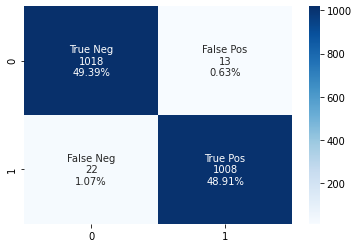

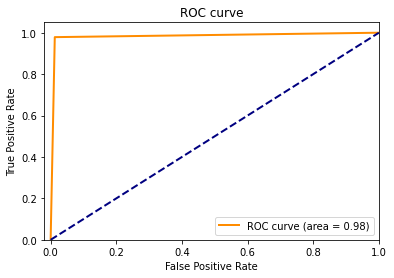

In [46]:
display_metrics(y_test, test_pred)

## Train LightGBM model

LightGBM Model. We can use a special library called optuna to help with hyperparameter tuning. A 3-fold cross validation is used to ensure we don't overfit the data. 

In [42]:
from sklearn.model_selection import KFold
import optuna.integration.lightgbm as lgb

dtrain = lightgbm.Dataset(X_train, label=y_train)
dval = lightgbm.Dataset(X_test, label=y_test)

In [ ]:
params = {
        "objective": "binary",
        "metric": "binary_logloss",
        "verbosity": -1,
        "boosting_type": "gbdt",
    }

tuner = lgb.LightGBMTunerCV(
    params, dtrain, verbose_eval=100, early_stopping_rounds=100, folds=KFold(n_splits=3)
)

tuner.run()

print("Best score:", tuner.best_score)
best_params = tuner.best_params
print("Best params:", best_params)
print("  Params: ")
for key, value in best_params.items():
    print("    {}: {}".format(key, value))

[I 2020-10-05 15:29:14,658] A new study created in memory with name: no-name-d0d0abf8-d7bb-4453-9a44-c791c44aee3d
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.047403 + 0.00292944
[200]	cv_agg's binary_logloss: 0.037099 + 0.00319882
[300]	cv_agg's binary_logloss: 0.0398273 + 0.00376792


feature_fraction, val_score: 0.036899:  14%|#4        | 1/7 [00:03<00:18,  3.11s/it]

[100]	cv_agg's binary_logloss: 0.0588742 + 0.0040209
[200]	cv_agg's binary_logloss: 0.0394496 + 0.00240104
[300]	cv_agg's binary_logloss: 0.0371159 + 0.00218233
[400]	cv_agg's binary_logloss: 0.0379496 + 0.00213534


feature_fraction, val_score: 0.036357:  29%|##8       | 2/7 [00:05<00:14,  2.98s/it]

[100]	cv_agg's binary_logloss: 0.0453816 + 0.00293519
[200]	cv_agg's binary_logloss: 0.0352044 + 0.0032991
[300]	cv_agg's binary_logloss: 0.0359456 + 0.00260762


feature_fraction, val_score: 0.034220:  43%|####2     | 3/7 [00:08<00:11,  2.95s/it]

[100]	cv_agg's binary_logloss: 0.053194 + 0.00322824
[200]	cv_agg's binary_logloss: 0.0368766 + 0.00347303
[300]	cv_agg's binary_logloss: 0.035529 + 0.00355484


feature_fraction, val_score: 0.034220:  57%|#####7    | 4/7 [00:11<00:08,  2.78s/it]

[100]	cv_agg's binary_logloss: 0.0479849 + 0.00332937
[200]	cv_agg's binary_logloss: 0.0345226 + 0.00247439
[300]	cv_agg's binary_logloss: 0.0349124 + 0.00427025


feature_fraction, val_score: 0.033840:  71%|#######1  | 5/7 [00:13<00:05,  2.74s/it]

[100]	cv_agg's binary_logloss: 0.0656604 + 0.00416491
[200]	cv_agg's binary_logloss: 0.0423936 + 0.00525173
[300]	cv_agg's binary_logloss: 0.0382231 + 0.00456538
[400]	cv_agg's binary_logloss: 0.0385726 + 0.00414172


feature_fraction, val_score: 0.033840:  86%|########5 | 6/7 [00:16<00:02,  2.65s/it]

[100]	cv_agg's binary_logloss: 0.049174 + 0.00156036
[200]	cv_agg's binary_logloss: 0.035523 + 0.00175125
[300]	cv_agg's binary_logloss: 0.0368694 + 0.00347663


num_leaves, val_score: 0.033840:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0426471 + 0.00191721
[200]	cv_agg's binary_logloss: 0.0456158 + 0.00414923


num_leaves, val_score: 0.033840:   5%|5         | 1/20 [00:04<01:19,  4.16s/it]

[100]	cv_agg's binary_logloss: 0.0440294 + 0.00232829
[200]	cv_agg's binary_logloss: 0.04625 + 0.00289268


num_leaves, val_score: 0.033840:  10%|#         | 2/20 [00:08<01:18,  4.33s/it]

[100]	cv_agg's binary_logloss: 0.042275 + 0.00259462
[200]	cv_agg's binary_logloss: 0.044679 + 0.00440857


num_leaves, val_score: 0.033840:  15%|#5        | 3/20 [00:12<01:11,  4.20s/it]

[100]	cv_agg's binary_logloss: 0.141547 + 0.000874459
[200]	cv_agg's binary_logloss: 0.10467 + 0.00274152
[300]	cv_agg's binary_logloss: 0.0846292 + 0.00418319
[400]	cv_agg's binary_logloss: 0.0706502 + 0.00402824
[500]	cv_agg's binary_logloss: 0.0603215 + 0.00412291
[600]	cv_agg's binary_logloss: 0.0529781 + 0.00434218
[700]	cv_agg's binary_logloss: 0.0488088 + 0.00461139
[800]	cv_agg's binary_logloss: 0.045092 + 0.00426366
[900]	cv_agg's binary_logloss: 0.0427284 + 0.00384938
[1000]	cv_agg's binary_logloss: 0.0407853 + 0.00390466


num_leaves, val_score: 0.033840:  20%|##        | 4/20 [00:15<01:00,  3.76s/it]

[100]	cv_agg's binary_logloss: 0.129406 + 0.00239491
[200]	cv_agg's binary_logloss: 0.0917431 + 0.00343483
[300]	cv_agg's binary_logloss: 0.0701402 + 0.0036658
[400]	cv_agg's binary_logloss: 0.0571896 + 0.00385596
[500]	cv_agg's binary_logloss: 0.0495914 + 0.00348197
[600]	cv_agg's binary_logloss: 0.0448112 + 0.00365851
[700]	cv_agg's binary_logloss: 0.041454 + 0.00329316
[800]	cv_agg's binary_logloss: 0.0391998 + 0.00306789
[900]	cv_agg's binary_logloss: 0.0376238 + 0.00304688
[1000]	cv_agg's binary_logloss: 0.0368536 + 0.00261118


num_leaves, val_score: 0.033840:  25%|##5       | 5/20 [00:18<00:53,  3.54s/it]

[100]	cv_agg's binary_logloss: 0.042138 + 0.00238946
[200]	cv_agg's binary_logloss: 0.0434149 + 0.00424376


num_leaves, val_score: 0.033840:  30%|###       | 6/20 [00:21<00:46,  3.34s/it]

[100]	cv_agg's binary_logloss: 0.0440294 + 0.00232829
[200]	cv_agg's binary_logloss: 0.04625 + 0.00289268


num_leaves, val_score: 0.033840:  35%|###5      | 7/20 [00:26<00:48,  3.73s/it]

[100]	cv_agg's binary_logloss: 0.0441027 + 0.00256001
[200]	cv_agg's binary_logloss: 0.0451763 + 0.004362


num_leaves, val_score: 0.033840:  40%|####      | 8/20 [00:29<00:42,  3.51s/it]

[100]	cv_agg's binary_logloss: 0.0446137 + 0.00201037
[200]	cv_agg's binary_logloss: 0.0465561 + 0.00302464


num_leaves, val_score: 0.033840:  45%|####5     | 9/20 [00:33<00:41,  3.81s/it]

[100]	cv_agg's binary_logloss: 0.0433863 + 0.00194017
[200]	cv_agg's binary_logloss: 0.0464878 + 0.00193648


num_leaves, val_score: 0.033840:  50%|#####     | 10/20 [00:36<00:35,  3.53s/it]

[100]	cv_agg's binary_logloss: 0.0446119 + 0.0033934
[200]	cv_agg's binary_logloss: 0.0370595 + 0.00243586


num_leaves, val_score: 0.033840:  55%|#####5    | 11/20 [00:39<00:29,  3.25s/it]

[100]	cv_agg's binary_logloss: 0.0440294 + 0.00232829
[200]	cv_agg's binary_logloss: 0.04625 + 0.00289268


num_leaves, val_score: 0.033840:  60%|######    | 12/20 [00:43<00:29,  3.65s/it]

[100]	cv_agg's binary_logloss: 0.042714 + 0.00302168
[200]	cv_agg's binary_logloss: 0.0446165 + 0.0035216


num_leaves, val_score: 0.033840:  65%|######5   | 13/20 [00:47<00:25,  3.62s/it]

[100]	cv_agg's binary_logloss: 0.0414794 + 0.00223192
[200]	cv_agg's binary_logloss: 0.0449524 + 0.00350998


num_leaves, val_score: 0.033840:  70%|#######   | 14/20 [00:50<00:21,  3.58s/it]

[100]	cv_agg's binary_logloss: 0.0444883 + 0.00183713
[200]	cv_agg's binary_logloss: 0.0465166 + 0.0027108


num_leaves, val_score: 0.033840:  75%|#######5  | 15/20 [00:55<00:19,  3.87s/it]

[100]	cv_agg's binary_logloss: 0.042958 + 0.00363422
[200]	cv_agg's binary_logloss: 0.0370339 + 0.00191279


num_leaves, val_score: 0.033840:  80%|########  | 16/20 [00:57<00:14,  3.53s/it]

[100]	cv_agg's binary_logloss: 0.0428773 + 0.00171016
[200]	cv_agg's binary_logloss: 0.0463722 + 0.00488136


num_leaves, val_score: 0.033840:  85%|########5 | 17/20 [01:01<00:11,  3.68s/it]

[100]	cv_agg's binary_logloss: 0.0436785 + 0.00257108
[200]	cv_agg's binary_logloss: 0.0465703 + 0.00430847


num_leaves, val_score: 0.033840:  90%|######### | 18/20 [01:05<00:07,  3.55s/it]

[100]	cv_agg's binary_logloss: 0.0486326 + 0.00323691
[200]	cv_agg's binary_logloss: 0.0360973 + 0.00121613
[300]	cv_agg's binary_logloss: 0.0365433 + 0.00156699


num_leaves, val_score: 0.033840:  95%|#########5| 19/20 [01:08<00:03,  3.33s/it]

[100]	cv_agg's binary_logloss: 0.0479849 + 0.00332937
[200]	cv_agg's binary_logloss: 0.0345226 + 0.00247439
[300]	cv_agg's binary_logloss: 0.0349124 + 0.00427025


bagging, val_score: 0.033840:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0460815 + 0.00202993
[200]	cv_agg's binary_logloss: 0.0331506 + 0.000893053
[300]	cv_agg's binary_logloss: 0.0331892 + 0.00390531


bagging, val_score: 0.031707:  10%|#         | 1/10 [00:03<00:28,  3.16s/it]

[100]	cv_agg's binary_logloss: 0.0482487 + 0.00283726
[200]	cv_agg's binary_logloss: 0.034093 + 0.00169488
[300]	cv_agg's binary_logloss: 0.0340677 + 0.00322485


bagging, val_score: 0.031707:  20%|##        | 2/10 [00:06<00:25,  3.16s/it]

[100]	cv_agg's binary_logloss: 0.0473002 + 0.00230921
[200]	cv_agg's binary_logloss: 0.0331783 + 0.00338234
[300]	cv_agg's binary_logloss: 0.0344715 + 0.00433946


bagging, val_score: 0.031707:  30%|###       | 3/10 [00:09<00:21,  3.08s/it]

[100]	cv_agg's binary_logloss: 0.0467595 + 0.00108026
[200]	cv_agg's binary_logloss: 0.0326269 + 0.00194073
[300]	cv_agg's binary_logloss: 0.03283 + 0.00324238


bagging, val_score: 0.031600:  40%|####      | 4/10 [00:12<00:18,  3.10s/it]

[100]	cv_agg's binary_logloss: 0.0473494 + 0.00263967
[200]	cv_agg's binary_logloss: 0.0341062 + 0.00172957
[300]	cv_agg's binary_logloss: 0.0346799 + 0.00316792


bagging, val_score: 0.031600:  50%|#####     | 5/10 [00:15<00:15,  3.13s/it]

[100]	cv_agg's binary_logloss: 0.0466143 + 0.00241989
[200]	cv_agg's binary_logloss: 0.0334894 + 0.00170592
[300]	cv_agg's binary_logloss: 0.0344459 + 0.00453197


bagging, val_score: 0.031600:  60%|######    | 6/10 [00:18<00:12,  3.14s/it]

[100]	cv_agg's binary_logloss: 0.0469983 + 0.00271893
[200]	cv_agg's binary_logloss: 0.0333704 + 0.00294192
[300]	cv_agg's binary_logloss: 0.0331976 + 0.00429328


bagging, val_score: 0.031600:  70%|#######   | 7/10 [00:21<00:09,  3.14s/it]

[100]	cv_agg's binary_logloss: 0.0473732 + 0.00220653
[200]	cv_agg's binary_logloss: 0.0329208 + 0.00170477
[300]	cv_agg's binary_logloss: 0.0332637 + 0.00388257


bagging, val_score: 0.031600:  80%|########  | 8/10 [00:25<00:06,  3.15s/it]

[100]	cv_agg's binary_logloss: 0.0451491 + 0.00234672
[200]	cv_agg's binary_logloss: 0.0309062 + 0.00284965
[300]	cv_agg's binary_logloss: 0.0292769 + 0.00396143


bagging, val_score: 0.029129:  90%|######### | 9/10 [00:28<00:03,  3.14s/it]

[100]	cv_agg's binary_logloss: 0.0461152 + 0.000895006
[200]	cv_agg's binary_logloss: 0.0305624 + 0.00229756
[300]	cv_agg's binary_logloss: 0.028448 + 0.00356484


feature_fraction_stage2, val_score: 0.028220:   0%|          | 0/6 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0461152 + 0.000895006
[200]	cv_agg's binary_logloss: 0.0305624 + 0.00229756
[300]	cv_agg's binary_logloss: 0.028448 + 0.00356484


feature_fraction_stage2, val_score: 0.028220:  17%|#6        | 1/6 [00:03<00:15,  3.20s/it]

[100]	cv_agg's binary_logloss: 0.0459601 + 0.00150706
[200]	cv_agg's binary_logloss: 0.0309677 + 0.00245834
[300]	cv_agg's binary_logloss: 0.0289302 + 0.00483227


feature_fraction_stage2, val_score: 0.028220:  33%|###3      | 2/6 [00:06<00:12,  3.21s/it]

[100]	cv_agg's binary_logloss: 0.0461152 + 0.000895006
[200]	cv_agg's binary_logloss: 0.0305624 + 0.00229756
[300]	cv_agg's binary_logloss: 0.028448 + 0.00356484


feature_fraction_stage2, val_score: 0.028220:  50%|#####     | 3/6 [00:09<00:09,  3.19s/it]

[100]	cv_agg's binary_logloss: 0.0496865 + 0.0024118
[200]	cv_agg's binary_logloss: 0.0313001 + 0.00291592
[300]	cv_agg's binary_logloss: 0.0292637 + 0.00480559
[400]	cv_agg's binary_logloss: 0.0307881 + 0.00512648


feature_fraction_stage2, val_score: 0.028220:  67%|######6   | 4/6 [00:12<00:06,  3.15s/it]

[100]	cv_agg's binary_logloss: 0.0459601 + 0.00150706
[200]	cv_agg's binary_logloss: 0.0309677 + 0.00245834
[300]	cv_agg's binary_logloss: 0.0289302 + 0.00483227


feature_fraction_stage2, val_score: 0.028220:  83%|########3 | 5/6 [00:15<00:03,  3.18s/it]

[100]	cv_agg's binary_logloss: 0.0496865 + 0.0024118
[200]	cv_agg's binary_logloss: 0.0313001 + 0.00291592
[300]	cv_agg's binary_logloss: 0.0292637 + 0.00480559
[400]	cv_agg's binary_logloss: 0.0307881 + 0.00512648


regularization_factors, val_score: 0.028220:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0467378 + 0.00135958
[200]	cv_agg's binary_logloss: 0.0308711 + 0.00077065
[300]	cv_agg's binary_logloss: 0.0286159 + 0.00249667
[400]	cv_agg's binary_logloss: 0.0297099 + 0.00348926


regularization_factors, val_score: 0.028220:   5%|5         | 1/20 [00:03<01:00,  3.19s/it]

[100]	cv_agg's binary_logloss: 0.0461181 + 0.00089517
[200]	cv_agg's binary_logloss: 0.0300954 + 0.00198968
[300]	cv_agg's binary_logloss: 0.0294349 + 0.00486461


regularization_factors, val_score: 0.028220:  10%|#         | 2/20 [00:06<00:56,  3.16s/it]

[100]	cv_agg's binary_logloss: 0.115692 + 0.000440858
[200]	cv_agg's binary_logloss: 0.101297 + 0.00178228


regularization_factors, val_score: 0.028220:  15%|#5        | 3/20 [00:07<00:42,  2.50s/it]

[100]	cv_agg's binary_logloss: 0.0461153 + 0.000895006
[200]	cv_agg's binary_logloss: 0.0300793 + 0.00298084
[300]	cv_agg's binary_logloss: 0.028384 + 0.00365444


regularization_factors, val_score: 0.028100:  20%|##        | 4/20 [00:10<00:43,  2.69s/it]

[100]	cv_agg's binary_logloss: 0.0461152 + 0.000895006
[200]	cv_agg's binary_logloss: 0.0305624 + 0.00229756
[300]	cv_agg's binary_logloss: 0.028448 + 0.00356483


regularization_factors, val_score: 0.028100:  25%|##5       | 5/20 [00:13<00:42,  2.83s/it]

[100]	cv_agg's binary_logloss: 0.0461152 + 0.000895006
[200]	cv_agg's binary_logloss: 0.0305624 + 0.00229756
[300]	cv_agg's binary_logloss: 0.028448 + 0.00356484


regularization_factors, val_score: 0.028100:  30%|###       | 6/20 [00:16<00:41,  2.93s/it]

[100]	cv_agg's binary_logloss: 0.0461152 + 0.000895006
[200]	cv_agg's binary_logloss: 0.0305624 + 0.00229756
[300]	cv_agg's binary_logloss: 0.028448 + 0.00356484


regularization_factors, val_score: 0.028100:  35%|###5      | 7/20 [00:19<00:38,  2.99s/it]

[100]	cv_agg's binary_logloss: 0.0461153 + 0.000895007
[200]	cv_agg's binary_logloss: 0.0300793 + 0.00298084
[300]	cv_agg's binary_logloss: 0.028384 + 0.00365446


regularization_factors, val_score: 0.028100:  40%|####      | 8/20 [00:22<00:36,  3.04s/it]

[100]	cv_agg's binary_logloss: 0.0461153 + 0.000895007
[200]	cv_agg's binary_logloss: 0.0300793 + 0.00298084
[300]	cv_agg's binary_logloss: 0.028384 + 0.00365449


regularization_factors, val_score: 0.028100:  45%|####5     | 9/20 [00:26<00:33,  3.08s/it]

[100]	cv_agg's binary_logloss: 0.0461153 + 0.000895008
[200]	cv_agg's binary_logloss: 0.0300794 + 0.00298085
[300]	cv_agg's binary_logloss: 0.0288664 + 0.00391138


regularization_factors, val_score: 0.028100:  50%|#####     | 10/20 [00:29<00:30,  3.07s/it]

[100]	cv_agg's binary_logloss: 0.0461153 + 0.000895008
[200]	cv_agg's binary_logloss: 0.0300793 + 0.00298085
[300]	cv_agg's binary_logloss: 0.0285988 + 0.00384801


regularization_factors, val_score: 0.028100:  55%|#####5    | 11/20 [00:32<00:27,  3.07s/it]

[100]	cv_agg's binary_logloss: 0.0461153 + 0.000895009
[200]	cv_agg's binary_logloss: 0.0300794 + 0.00298085
[300]	cv_agg's binary_logloss: 0.0293376 + 0.00318037


regularization_factors, val_score: 0.028100:  60%|######    | 12/20 [00:35<00:24,  3.09s/it]

[100]	cv_agg's binary_logloss: 0.0461158 + 0.000895023
[200]	cv_agg's binary_logloss: 0.0307348 + 0.0025079
[300]	cv_agg's binary_logloss: 0.0281279 + 0.00492094


regularization_factors, val_score: 0.027952:  65%|######5   | 13/20 [00:38<00:21,  3.12s/it]

[100]	cv_agg's binary_logloss: 0.0460478 + 0.000779517
[200]	cv_agg's binary_logloss: 0.0294711 + 0.0023115
[300]	cv_agg's binary_logloss: 0.0271426 + 0.00339124


regularization_factors, val_score: 0.027131:  70%|#######   | 14/20 [00:41<00:18,  3.12s/it]

[100]	cv_agg's binary_logloss: 0.0473119 + 0.000482593
[200]	cv_agg's binary_logloss: 0.0301677 + 0.00136259
[300]	cv_agg's binary_logloss: 0.0274179 + 0.00243098


regularization_factors, val_score: 0.027131:  75%|#######5  | 15/20 [00:44<00:15,  3.13s/it]

[100]	cv_agg's binary_logloss: 0.047791 + 0.00090632
[200]	cv_agg's binary_logloss: 0.0313715 + 0.00152818
[300]	cv_agg's binary_logloss: 0.028954 + 0.00127332
[400]	cv_agg's binary_logloss: 0.0299348 + 0.00220011


regularization_factors, val_score: 0.027131:  80%|########  | 16/20 [00:48<00:12,  3.16s/it]

[100]	cv_agg's binary_logloss: 0.0463547 + 0.000956449
[200]	cv_agg's binary_logloss: 0.0290565 + 0.00185767
[300]	cv_agg's binary_logloss: 0.0266851 + 0.00261775


regularization_factors, val_score: 0.026509:  85%|########5 | 17/20 [00:51<00:09,  3.15s/it]

[100]	cv_agg's binary_logloss: 0.0466111 + 0.0011354
[200]	cv_agg's binary_logloss: 0.0299584 + 0.00166866
[300]	cv_agg's binary_logloss: 0.027941 + 0.00345133
[400]	cv_agg's binary_logloss: 0.0286728 + 0.00514797


regularization_factors, val_score: 0.026509:  90%|######### | 18/20 [00:54<00:06,  3.19s/it]

[100]	cv_agg's binary_logloss: 0.0467826 + 0.0014085
[200]	cv_agg's binary_logloss: 0.0304094 + 0.00224334
[300]	cv_agg's binary_logloss: 0.0295904 + 0.0031395
[400]	cv_agg's binary_logloss: 0.0316924 + 0.00414233


regularization_factors, val_score: 0.026509:  95%|#########5| 19/20 [00:57<00:03,  3.21s/it]

[100]	cv_agg's binary_logloss: 0.046433 + 0.00102817
[200]	cv_agg's binary_logloss: 0.0297043 + 0.00186428
[300]	cv_agg's binary_logloss: 0.0284239 + 0.00411145
[400]	cv_agg's binary_logloss: 0.0303957 + 0.00458209


min_data_in_leaf, val_score: 0.026509:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_logloss: 0.0796414 + 0.00256199
[200]	cv_agg's binary_logloss: 0.0449069 + 0.000756183
[300]	cv_agg's binary_logloss: 0.0346849 + 0.00123649
[400]	cv_agg's binary_logloss: 0.0318706 + 0.00218619
[500]	cv_agg's binary_logloss: 0.0310171 + 0.00292638
[600]	cv_agg's binary_logloss: 0.031045 + 0.00460655


min_data_in_leaf, val_score: 0.026509:  20%|##        | 1/5 [00:03<00:13,  3.42s/it]

[100]	cv_agg's binary_logloss: 0.043883 + 0.00155366
[200]	cv_agg's binary_logloss: 0.0289855 + 0.00290074
[300]	cv_agg's binary_logloss: 0.0272637 + 0.00321319


min_data_in_leaf, val_score: 0.026509:  40%|####      | 2/5 [00:06<00:10,  3.42s/it]

[100]	cv_agg's binary_logloss: 0.0449936 + 0.000326514
[200]	cv_agg's binary_logloss: 0.029696 + 0.0012626
[300]	cv_agg's binary_logloss: 0.0284103 + 0.00344157


min_data_in_leaf, val_score: 0.026509:  60%|######    | 3/5 [00:09<00:06,  3.32s/it]

[100]	cv_agg's binary_logloss: 0.0540189 + 0.0020561
[200]	cv_agg's binary_logloss: 0.0311722 + 0.00211926
[300]	cv_agg's binary_logloss: 0.0274492 + 0.00325859
[400]	cv_agg's binary_logloss: 0.0285689 + 0.00481709


min_data_in_leaf, val_score: 0.026509:  80%|########  | 4/5 [00:12<00:03,  3.18s/it]

[100]	cv_agg's binary_logloss: 0.0466213 + 0.00137368
[200]	cv_agg's binary_logloss: 0.0295902 + 0.00272697
[300]	cv_agg's binary_logloss: 0.0279657 + 0.00398367
[400]	cv_agg's binary_logloss: 0.0292231 + 0.00516025


min_data_in_leaf, val_score: 0.026509: 100%|##########| 5/5 [00:15<00:00,  3.19s/it]


Best score: 0.02650901912582367
Best params: {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.9303971415630697e-07, 'lambda_l2': 0.0011762868137770127, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 0.47492481081229176, 'bagging_freq': 1, 'min_child_samples': 20}
  Params: 
    objective: binary
    metric: binary_logloss
    verbosity: -1
    boosting_type: gbdt
    feature_pre_filter: False
    lambda_l1: 1.9303971415630697e-07
    lambda_l2: 0.0011762868137770127
    num_leaves: 31
    feature_fraction: 0.8
    bagging_fraction: 0.47492481081229176
    bagging_freq: 1
    min_child_samples: 20


In [35]:
best_params = {'objective': 'binary', 'metric': 'binary_logloss', 'verbosity': -1, 'boosting_type': 'gbdt', 'feature_pre_filter': False, 'lambda_l1': 1.9303971415630697e-07, 'lambda_l2': 0.0011762868137770127, 'num_leaves': 31, 'feature_fraction': 0.8, 'bagging_fraction': 0.47492481081229176, 'bagging_freq': 1, 'min_child_samples': 20}


In [43]:
#Train model with best parameters
lightgbm_model = lightgbm.train(
    best_params, dtrain, num_boost_round=1000, verbose_eval=100)

In [47]:
# Evaluate the model with confusion matrix
y = lightgbm_model.predict(X_test)
lgtest_pred = []
for val in y[:,]:
  if val >= 0.5:
      lgtest_pred.append(1)
  else :
      lgtest_pred.append(0)

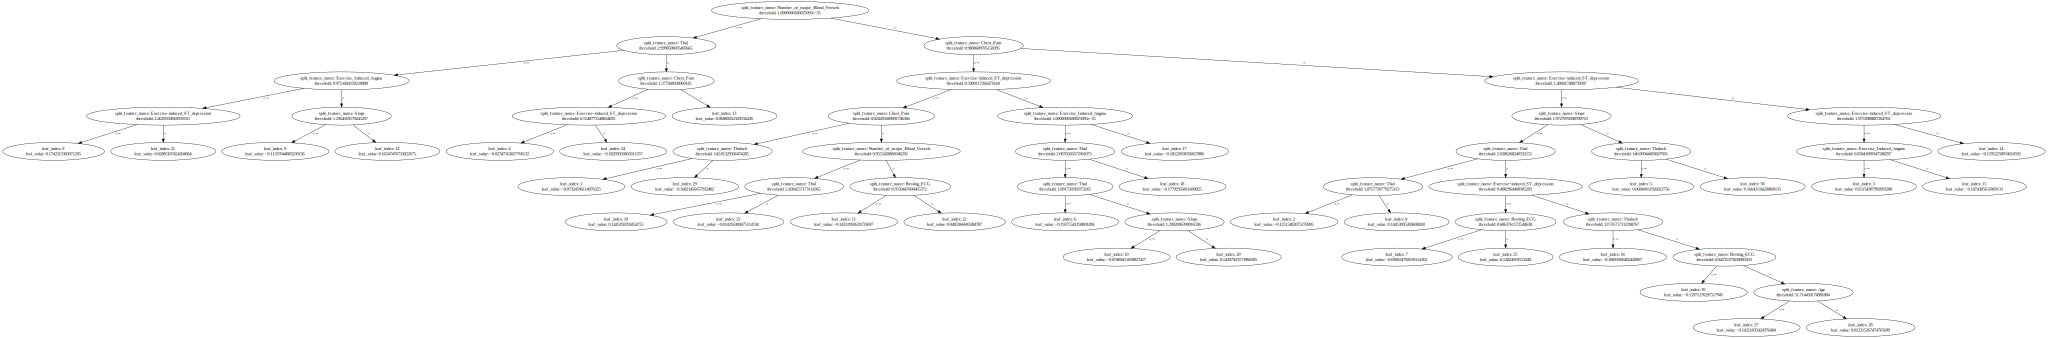

In [48]:
# Take a look at one of the trees in the lightGBM ensemble
from lightgbm import create_tree_digraph
gr = create_tree_digraph(lightgbm_model,1)
gr

Display the Confusion Matrix and Model Analysis

Confusion Matrix
[[1026    5]
 [   8 1022]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1031
         1.0       1.00      0.99      0.99      1030

    accuracy                           0.99      2061
   macro avg       0.99      0.99      0.99      2061
weighted avg       0.99      0.99      0.99      2061

Accuracy:
0.99


Recall: 
0.99


Precision: 
1.00


Specificity: 
1.00


Negative Predictive Value:
0.99




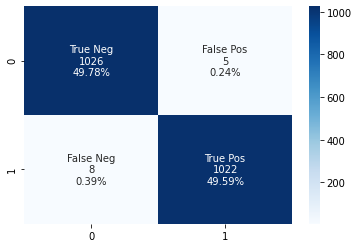

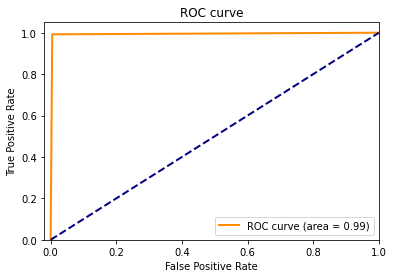

In [49]:
display_metrics(y_test, lgtest_pred)

## Train AdaBoost model

In [56]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(n_estimators=100, random_state=0)
clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=100, random_state=0)

Confusion Matrix
[[962  69]
 [ 66 964]]
              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93      1031
         1.0       0.93      0.94      0.93      1030

    accuracy                           0.93      2061
   macro avg       0.93      0.93      0.93      2061
weighted avg       0.93      0.93      0.93      2061

Accuracy:
0.93


Recall: 
0.94


Precision: 
0.93


Specificity: 
0.93


Negative Predictive Value:
0.94




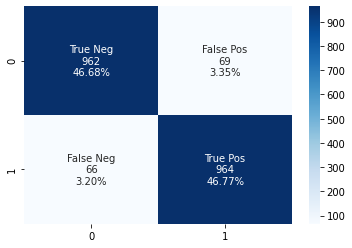

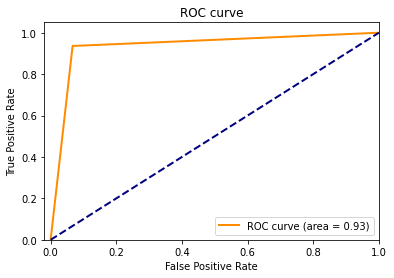

In [57]:
adatest_preds = clf.predict(X_test)
display_metrics(y_test, adatest_preds)

The AdaBoost model is fairly mediocre. On nearly every metric, it does substantially better than logistic regression or naive Bayes (though logistic regression is better on specificity), and slightly better than SVM. But it's significantly worse on every metric than LightGBM or XGBoost.

## Train SVM model

In [50]:
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn import metrics

svm_classifier = svm.SVC(kernel='linear')
svm_classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

Find predicted outcome values

In [51]:
svmtest_preds = svm_classifier.predict(X_test)

Display the Confusion Matrix and Model Analysis

Confusion Matrix
[[900 131]
 [ 79 951]]
              precision    recall  f1-score   support

         0.0       0.92      0.87      0.90      1031
         1.0       0.88      0.92      0.90      1030

    accuracy                           0.90      2061
   macro avg       0.90      0.90      0.90      2061
weighted avg       0.90      0.90      0.90      2061

Accuracy:
0.90


Recall: 
0.92


Precision: 
0.87


Specificity: 
0.88


Negative Predictive Value:
0.92




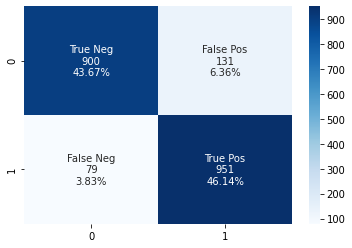

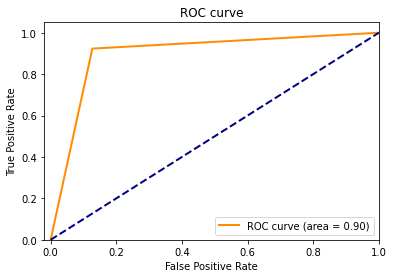

In [52]:
display_metrics(y_test, svmtest_preds)


## Train Gaussian Naive Bayes model 

In [53]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnbModel = gnb.fit(X_train, y_train)

Find predicted outcome values

In [54]:
gnbtest_pred = gnbModel.predict(X_test)

Display Confusion Matrix and Model Analysis

Confusion Matrix
[[885 146]
 [ 99 931]]
              precision    recall  f1-score   support

         0.0       0.90      0.86      0.88      1031
         1.0       0.86      0.90      0.88      1030

    accuracy                           0.88      2061
   macro avg       0.88      0.88      0.88      2061
weighted avg       0.88      0.88      0.88      2061

Accuracy:
0.88


Recall: 
0.90


Precision: 
0.86


Specificity: 
0.86


Negative Predictive Value:
0.90




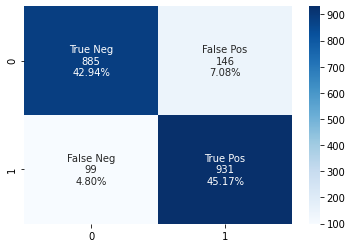

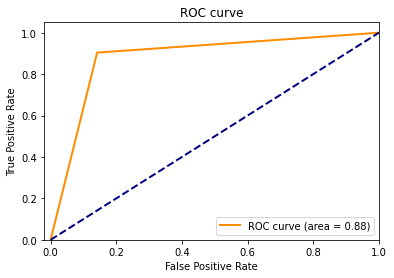

In [55]:
display_metrics(y_test,gnbtest_pred)

In comparison to the other models, the Gaussian Naive Bayes model performs the second worst (very closely following the Logistic Regression model). The accuracy of this model was 0.88, which is lower than all other models except for Logistic Regresion. In addition to accuracy, it also outperforms Logistic Regresiion in Recall and Negative Predictive Value, though the values still remain low in comparison to the other models. The Gaussian Naive Bayes model also had the highest False Pos and the second highest False Neg, making it not very reliable. Ultimately, these poor performance results suggest that this model is not ideal for this situation. 

## Train Logistic Regression Model


Training the Model

In [58]:
from sklearn import preprocessing

X_scaled = preprocessing.scale(X_train)

In [59]:

from sklearn.linear_model import SGDClassifier

logreg = SGDClassifier(loss = 'log')
logreg.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

Predict Outcomes

In [62]:
logtest_preds = logreg.predict(X_test)

Model Analysis and Confusion Matrix

Confusion Matrix
[[977  54]
 [206 824]]
              precision    recall  f1-score   support

         0.0       0.83      0.95      0.88      1031
         1.0       0.94      0.80      0.86      1030

    accuracy                           0.87      2061
   macro avg       0.88      0.87      0.87      2061
weighted avg       0.88      0.87      0.87      2061

Accuracy:
0.87


Recall: 
0.83


Precision: 
0.95


Specificity: 
0.94


Negative Predictive Value:
0.80




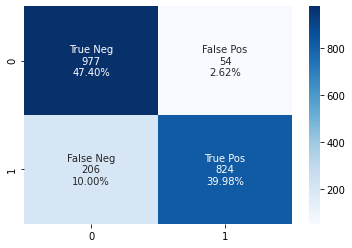

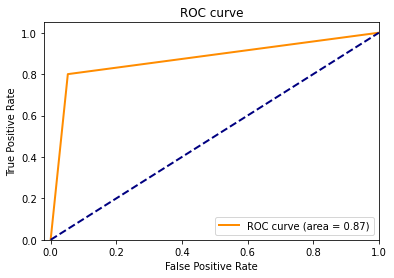

In [63]:
display_metrics(y_test, logtest_preds)

Out of all the models we tried, the Logistic Regression model performs the worst of the bunch. It seems to overclassify the absence of heart disease. The misclassifications likely have to do with a couple of different features of Logistic Regression. First of all, Logistic regression assigns probabilities to the outcome, so depending on where the model decides to differentiate between 0 and 1 will affect the performance. If the split was at 80%, meaning that any outcome with probabilities 80 % and larger would be 1 and lower would be 0, then we might have a lot of false negatives, which occurs in this model. In addition, logistic regression is likely to struggle at capturing non linear relationships between predictor and outcome variables, which would make it harder to accurately assign probabilities to observations.

## Final Results

In [83]:
res_data = [['lightGBM', 0.99, 0.99, 1.00, 1.00, 0.99], ['xgboost', 0.98, 0.98, 0.99, 0.99, 0.98], ['Adaboost', 0.93, 0.94, 0.93, 0.93, 0.94], ['SVM', 0.90, 0.92, 0.87, 0.88, 0.92], ['Naive Gaussian Bayes', 0.88, 0.90, 0.86, 0.86, 0.90], ['Logistic Regression', 0.87, 0.83, 0.95, 0.94, 0.80]];
results = pd.DataFrame(res_data, columns = ['Classifier', 'Accuracy:', 'Recall:', 'Precision:', 'Specificity: ', 'Negative Predictive Value:']) 
results

,Classifier,Accuracy:,Recall:,Precision:,Specificity:,Negative Predictive Value:
0,lightGBM,0.99,0.99,1.00,1.00,0.99
1,xgboost,0.98,0.98,0.99,0.99,0.98
2,Adaboost,0.93,0.94,0.93,0.93,0.94
3,SVM,0.90,0.92,0.87,0.88,0.92
4,Naive Gaussian Bayes,0.88,0.90,0.86,0.86,0.90
5,Logistic Regression,0.87,0.83,0.95,0.94,0.80


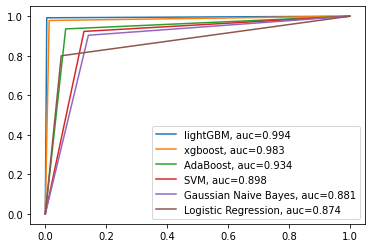

In [77]:
pl.figure(0).clf()

label = y_test
pred = lgtest_pred
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
pl.plot(fpr,tpr,label="lightGBM, auc="+str(round(auc, 3)))

label = y_test
pred = test_pred
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
pl.plot(fpr,tpr,label="xgboost, auc="+str(round(auc, 3)))

label = y_test
pred = adatest_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
pl.plot(fpr,tpr,label="AdaBoost, auc="+str(round(auc, 3)))

label = y_test
pred = svmtest_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
pl.plot(fpr,tpr,label="SVM, auc="+str(round(auc, 3)))

label = y_test
pred = gnbtest_pred
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
pl.plot(fpr,tpr,label="Gaussian Naive Bayes, auc="+str(round(auc, 3)))

label = y_test
pred = logtest_preds
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
pl.plot(fpr,tpr,label="Logistic Regression, auc="+str(round(auc, 3)))


pl.legend(loc=0)

We can see that LightGBM performed the best in all categories, with XGBoost in second place. It's important to note that LightGBM also took significantly fewer iterations, and thus was more efficient for this data set.

## Creating a Web Calculator
Use our best model to predict the likelihood of heart disease based on inputted 
predictors

Here is what the web app looks like:

In [64]:
import IPython
IPython.display.HTML("/content/drive/My Drive/AI In Healthcare/Project 2/index.html")

In [69]:
# Run this cell and open the second link to access the rendered webapp. 
app = Flask(__name__, template_folder='drive/My Drive/AI In Healthcare/Project 2')
run_with_ngrok(app)

@app.route('/')
def home():
  return render_template("index.html")

@app.route('/submit', methods=['GET', 'POST'])
def submit():

  if request.method == 'POST':
    req = request.form.to_dict()
    for key in req:
        req[key] = float(req[key])
    df = pd.DataFrame([req.values()], columns=req.keys())
    #result = str("{:.2f}".format(xgb2.predict_proba(df)[:,1][0] * 100) + '%')
    arr = np.array(lightgbm_model.predict(df)) 
    #npstring = np.array_str(arr)
    #result = str(format(npstring) + '%')
    result = str("{:.2f}".format(float(arr) * 100) + '%')
    #result = model.predict(df)
    return render_template("index.html", result=result)
  return render_template("index.html")

if __name__ =='__main__':
  app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://4ada019afd42.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [05/Oct/2020 16:40:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2020 16:40:26] "GET /favicon.ico HTTP/1.1" 404 -
127.0.0.1 - - [05/Oct/2020 16:40:27] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2020 16:42:45] "POST /submit HTTP/1.1" 200 -
127.0.0.1 - - [05/Oct/2020 16:42:46] "GET /submit HTTP/1.1" 200 -
